In [1]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from collections import Counter
from scipy.stats import ttest_ind, pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.max_columns',None)

In [4]:
df = pd.read_csv('heart_2022_with_nans.csv')
df

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",NaN,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,No,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 18 to 24,1.65,69.85,25.63,NaN,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
445128,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 50 to 54,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
445129,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,No,No,No,No,No,No,No,No,No,No,No,NaN,No,No,No,Current smoker - now smokes every day,Use them some days,NaN,NaN,Age 65 to 69,1.70,49.90,17.23,NaN,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
445130,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 70 to 74,1.83,108.86,32.55,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes


In [5]:
# Describe the dataset and its features.
df.info()
df.shape
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


In [6]:
#Checkin for missing values
missing_values = df.isnull().sum()
print(missing_values)

State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategor

In [7]:
# Define a threshold for removing columns with too many missing values
threshold = 0.5  # This means we will drop columns with more than 50% missing values

# Calculate the threshold number of missing values
threshold_value = len(df) * threshold

# Drop columns with more than the threshold number of missing values
df = df.dropna(thresh=threshold_value, axis=1)

# Display the remaining columns after dropping
print("Columns remaining after dropping:")
print(df.columns)

# Fill missing values for numeric columns with their mean
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values for categorical columns with their mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Display the number of remaining missing values
print("Remaining missing values:")
print(df.isnull().sum())

Columns remaining after dropping:
Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Remaining missing values:
State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
M

In [8]:
# Duplicate values
df.duplicated()
df.duplicated().sum()

305

In [9]:
df.drop_duplicates(keep='first',inplace=True)

In [10]:
df.duplicated().sum()

0

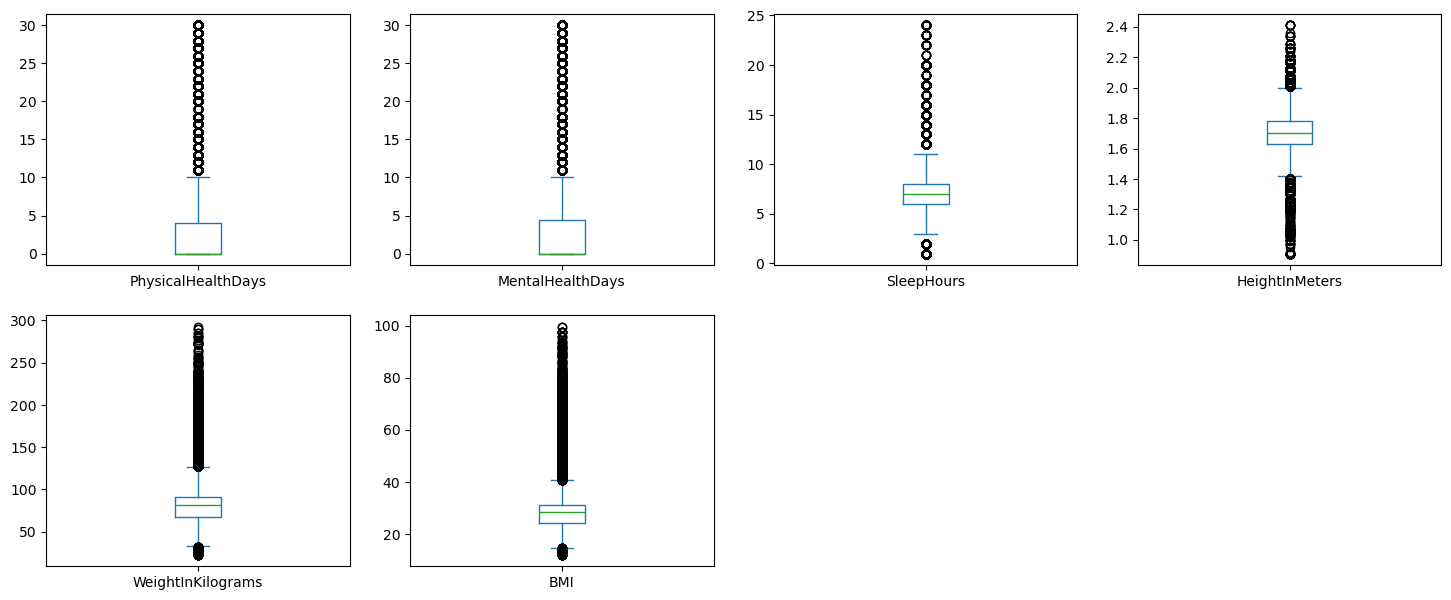

In [11]:
df.plot(kind = "box" , subplots = True , figsize = (18,15) , layout = (4,4))
plt.show()

In [12]:
# Convert specified columns to numeric data type, coercing errors to NaN
df[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]] = df[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].apply(pd.to_numeric, errors='coerce')

# Calculate the first and third quartiles for the specified columns
q1 = df[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].quantile(q=0.25)
q3 = df[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].quantile(q=0.75)

# Calculate the interquartile range (IQR) for the specified columns
IQR = q3 - q1

# Calculate the lower and upper bounds for outliers for the specified columns
IQR_lower_limit = q1 - 1.5 * IQR
IQR_upper_limit = q3 + 1.5 * IQR

# Identify outliers based on the specified columns
outliers = df[(df["PhysicalHealthDays"] < IQR_lower_limit["PhysicalHealthDays"]) | 
              (df["PhysicalHealthDays"] > IQR_upper_limit["PhysicalHealthDays"]) |
              (df["MentalHealthDays"] < IQR_lower_limit["MentalHealthDays"]) | 
              (df["MentalHealthDays"] > IQR_upper_limit["MentalHealthDays"]) |
              (df["SleepHours"] < IQR_lower_limit["SleepHours"]) | 
              (df["SleepHours"] > IQR_upper_limit["SleepHours"]) |
              (df["HeightInMeters"] < IQR_lower_limit["HeightInMeters"]) | 
              (df["HeightInMeters"] > IQR_upper_limit["HeightInMeters"]) |
              (df["WeightInKilograms"] < IQR_lower_limit["WeightInKilograms"]) | 
              (df["WeightInKilograms"] > IQR_upper_limit["WeightInKilograms"]) |
              (df["BMI"] < IQR_lower_limit["BMI"]) | 
              (df["BMI"] > IQR_upper_limit["BMI"])]

# Handle outliers by removing them
data = df[(df["PhysicalHealthDays"] >= IQR_lower_limit["PhysicalHealthDays"]) & 
           (df["PhysicalHealthDays"] <= IQR_upper_limit["PhysicalHealthDays"]) &
           (df["MentalHealthDays"] >= IQR_lower_limit["MentalHealthDays"]) & 
           (df["MentalHealthDays"] <= IQR_upper_limit["MentalHealthDays"]) &
           (df["SleepHours"] >= IQR_lower_limit["SleepHours"]) & 
           (df["SleepHours"] <= IQR_upper_limit["SleepHours"]) &
           (df["HeightInMeters"] >= IQR_lower_limit["HeightInMeters"]) & 
           (df["HeightInMeters"] <= IQR_upper_limit["HeightInMeters"]) &
           (df["WeightInKilograms"] >= IQR_lower_limit["WeightInKilograms"]) & 
           (df["WeightInKilograms"] <= IQR_upper_limit["WeightInKilograms"]) &
           (df["BMI"] >= IQR_lower_limit["BMI"]) & 
           (df["BMI"] <= IQR_upper_limit["BMI"])]

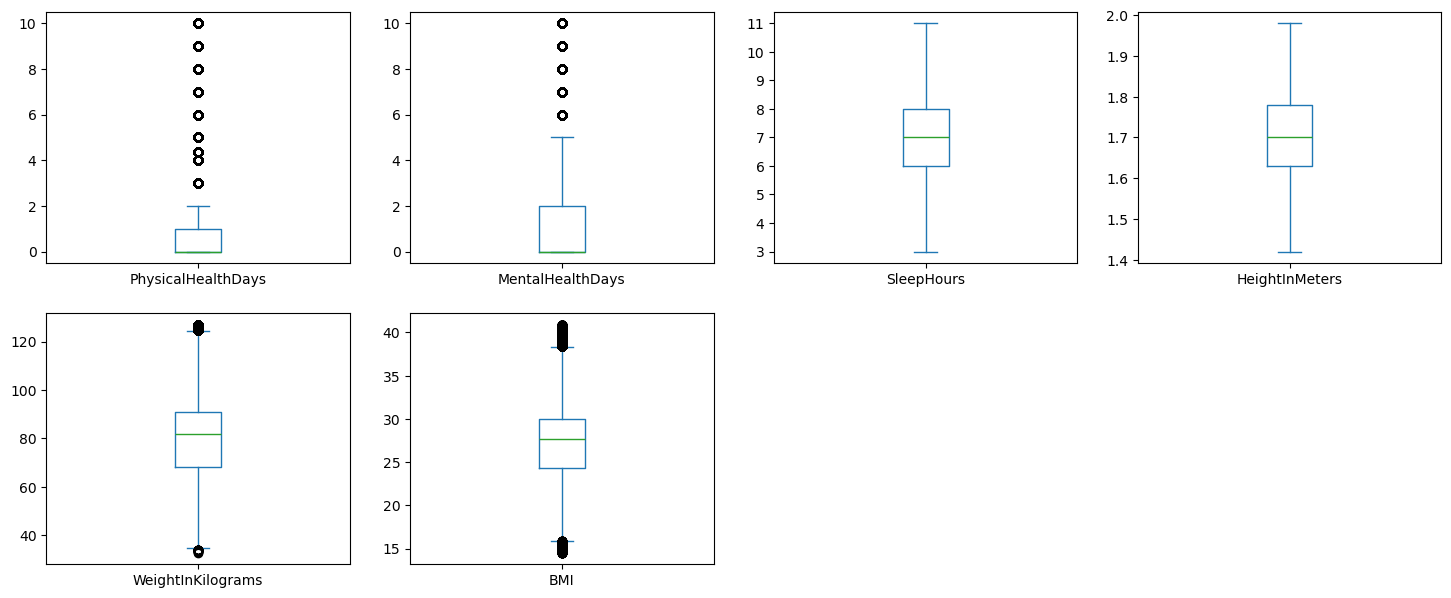

In [13]:
data.plot(kind = "box" , subplots = True , figsize = (18,15) , layout = (4,4))
plt.show()

In [14]:
# Convert specified columns to numeric data type, coercing errors to NaN
data[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]] = df[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].apply(pd.to_numeric, errors='coerce')

# Calculate the first and third quartiles for the specified columns
q1 = data[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].quantile(q=0.25)
q3 = data[["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]].quantile(q=0.75)

# Calculate the interquartile range (IQR) for the specified columns
IQR = q3 - q1

# Calculate the lower and upper bounds for outliers for the specified columns
IQR_lower_limit = q1 - 1.5 * IQR
IQR_upper_limit = q3 + 1.5 * IQR

# Identify outliers based on the specified columns
outliers = data[(data["PhysicalHealthDays"] < IQR_lower_limit["PhysicalHealthDays"]) | 
              (data["PhysicalHealthDays"] > IQR_upper_limit["PhysicalHealthDays"]) |
              (data["MentalHealthDays"] < IQR_lower_limit["MentalHealthDays"]) | 
              (data["MentalHealthDays"] > IQR_upper_limit["MentalHealthDays"]) |
              (data["SleepHours"] < IQR_lower_limit["SleepHours"]) | 
              (data["SleepHours"] > IQR_upper_limit["SleepHours"]) |
              (data["HeightInMeters"] < IQR_lower_limit["HeightInMeters"]) | 
              (data["HeightInMeters"] > IQR_upper_limit["HeightInMeters"]) |
              (data["WeightInKilograms"] < IQR_lower_limit["WeightInKilograms"]) | 
              (data["WeightInKilograms"] > IQR_upper_limit["WeightInKilograms"]) |
              (data["BMI"] < IQR_lower_limit["BMI"]) | 
              (data["BMI"] > IQR_upper_limit["BMI"])]

# Handle outliers by removing them
data2 = data[(data["PhysicalHealthDays"] >= IQR_lower_limit["PhysicalHealthDays"]) & 
           (data["PhysicalHealthDays"] <= IQR_upper_limit["PhysicalHealthDays"]) &
           (data["MentalHealthDays"] >= IQR_lower_limit["MentalHealthDays"]) & 
           (data["MentalHealthDays"] <= IQR_upper_limit["MentalHealthDays"]) &
           (data["SleepHours"] >= IQR_lower_limit["SleepHours"]) & 
           (data["SleepHours"] <= IQR_upper_limit["SleepHours"]) &
           (data["HeightInMeters"] >= IQR_lower_limit["HeightInMeters"]) & 
           (data["HeightInMeters"] <= IQR_upper_limit["HeightInMeters"]) &
           (data["WeightInKilograms"] >= IQR_lower_limit["WeightInKilograms"]) & 
           (data["WeightInKilograms"] <= IQR_upper_limit["WeightInKilograms"]) &
           (data["BMI"] >= IQR_lower_limit["BMI"]) & 
           (data["BMI"] <= IQR_upper_limit["BMI"])]

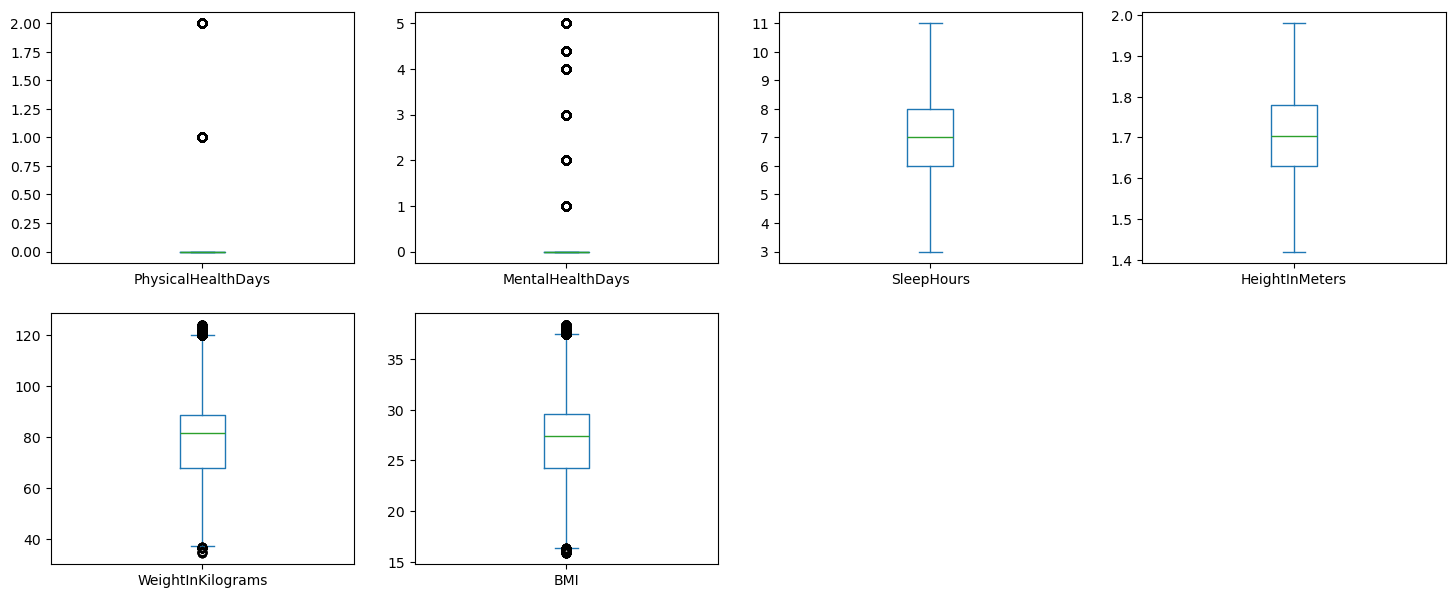

In [15]:
data2.plot(kind = "box" , subplots = True , figsize = (18,15) , layout = (4,4))
plt.show()

In [16]:
# Exploration Phase
col = list(data2.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data2[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex GeneralHealth PhysicalHealthDays LastCheckupTime PhysicalActivities RemovedTeeth HadHeartAttack HadAngina HadStroke HadAsthma HadSkinCancer HadCOPD HadDepressiveDisorder HadKidneyDisease HadArthritis HadDiabetes DeafOrHardOfHearing BlindOrVisionDifficulty DifficultyConcentrating DifficultyWalking DifficultyDressingBathing DifficultyErrands SmokerStatus ECigaretteUsage ChestScan RaceEthnicityCategory AlcoholDrinkers HIVTesting FluVaxLast12 PneumoVaxEver TetanusLast10Tdap HighRiskLastYear CovidPos
Numerical Features : State MentalHealthDays SleepHours AgeCategory HeightInMeters WeightInKilograms BMI


In [17]:
for col in data2.describe(include='object').columns:
    print('Column Name: ',col)
    print(data2[col].unique())
    print('-------------------------------------------------')

Column Name:  State
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
-------------------------------------------------
Column Name:  Sex
['Female' 'Male']
-------------------------------------------------
Column Name:  GeneralHealth
['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
-------------------------------------------------
Column Name:  LastCheckupTime
['Within past year (anytime less than 12 mont

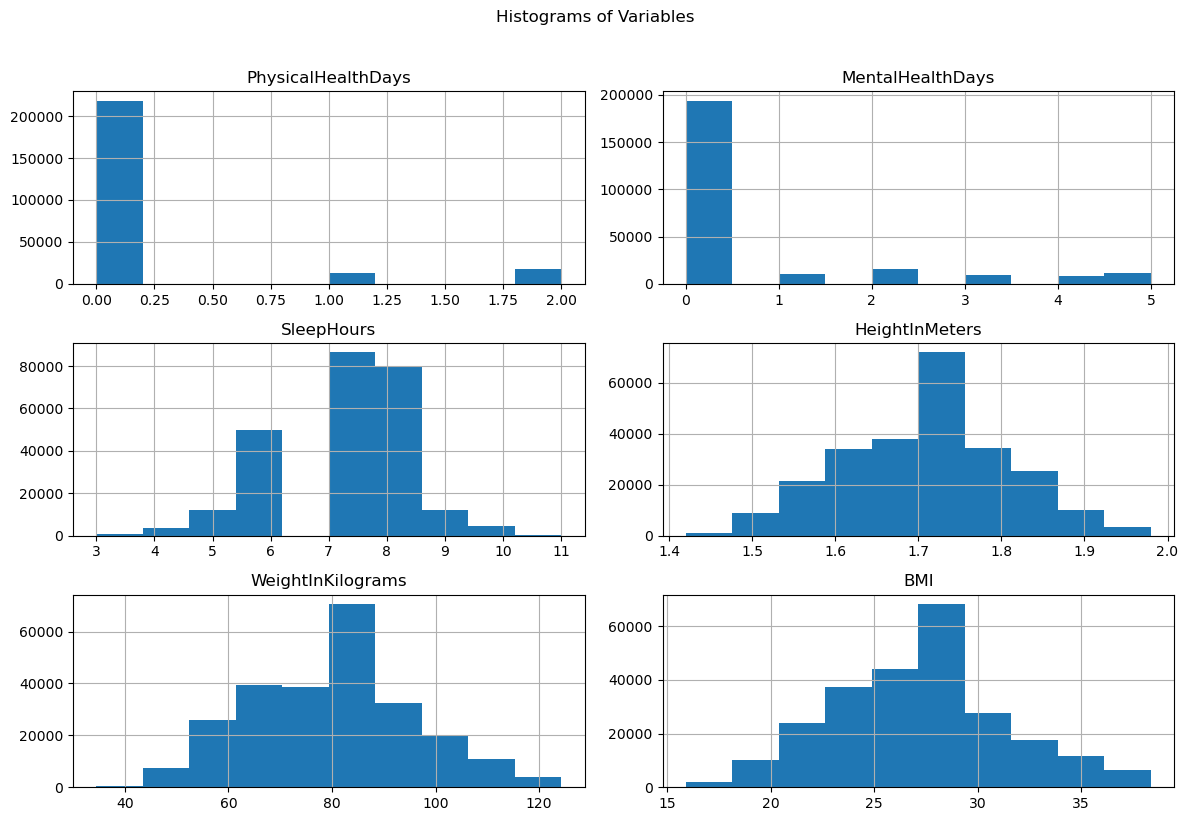

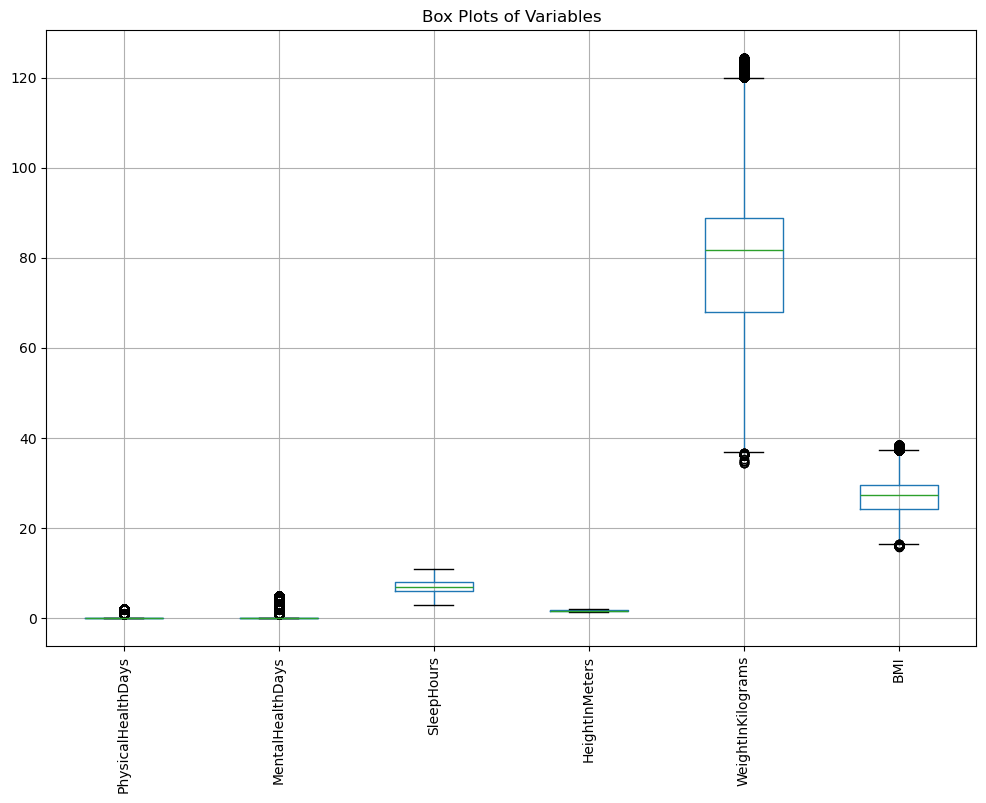

In [18]:
# Explore the distribution of numerical features
# Univariate Analysis
# Summary statistics
summary_stats = data2.describe()

# Histograms
data2.hist(figsize=(12, 8))
plt.suptitle('Histograms of Variables', y=1.02)
plt.tight_layout()
plt.show()

# Box plots
data2.boxplot(figsize=(12, 8))
plt.title('Box Plots of Variables')
plt.xticks(rotation=90)
plt.show()


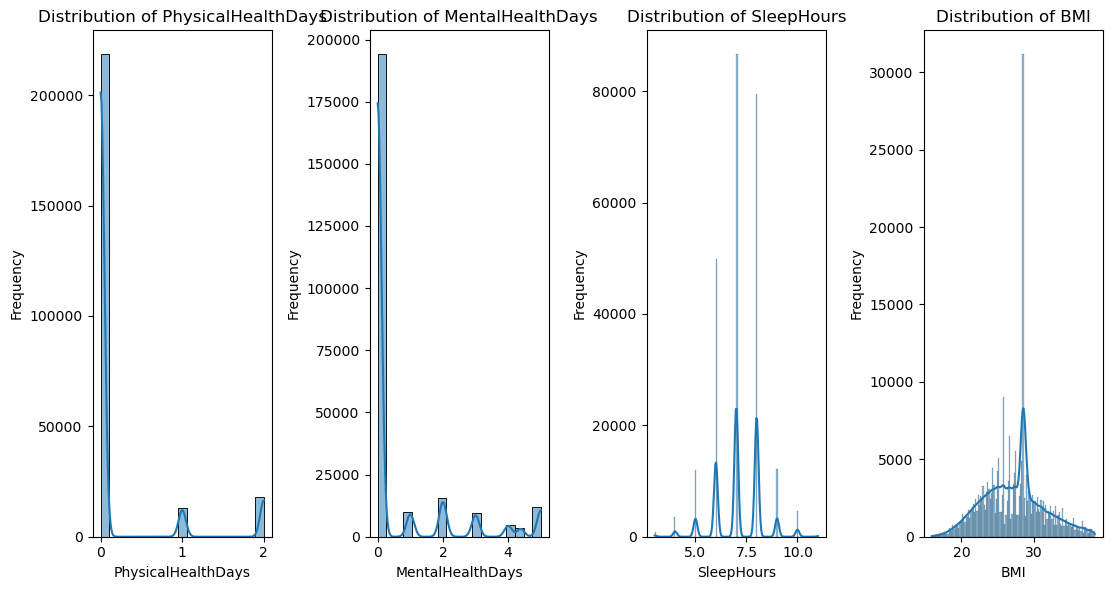

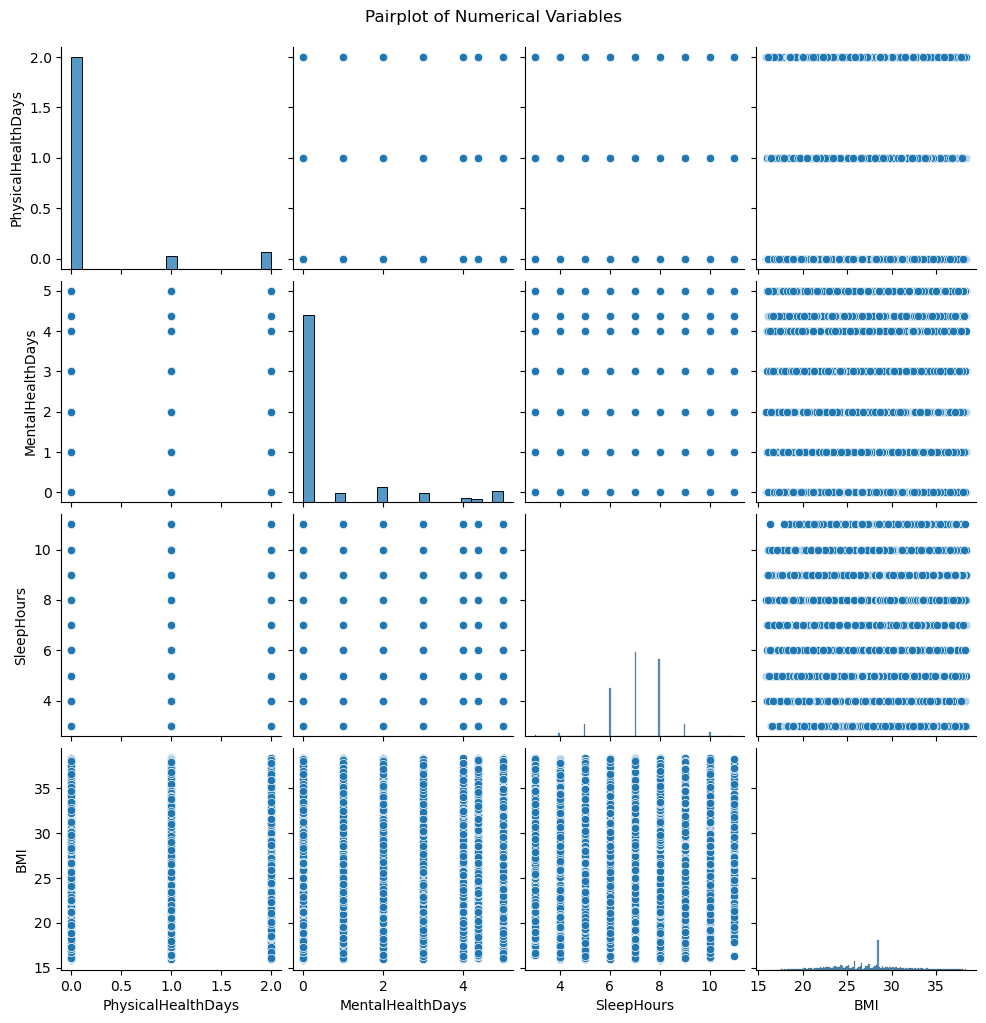

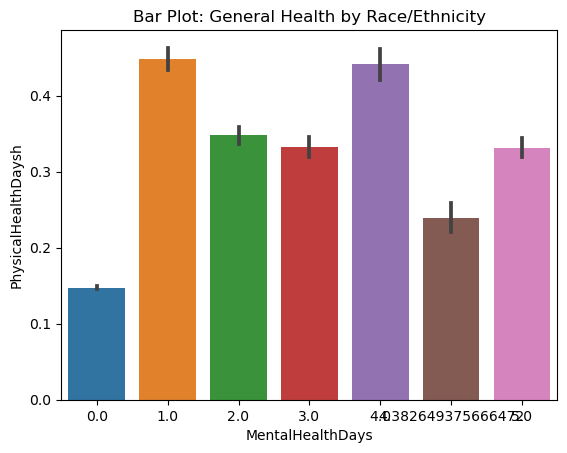

In [19]:
# Bivariate Analysis
#Distribution and Relationships of Numerical Variables
numerical_vars = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']
# Plot histograms for numerical variables
plt.figure(figsize=(14, 6))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(1, 5, i)
    sns.histplot(data2[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Pairplot to visualize relationships between numerical variables
sns.pairplot(data2[numerical_vars])
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

# Bar plots for comparing distributions across categories
sns.barplot(x='MentalHealthDays', y='PhysicalHealthDays', data=data2)
plt.title('Bar Plot: General Health by Race/Ethnicity')
plt.xlabel('MentalHealthDays')
plt.ylabel('PhysicalHealthDaysh')
plt.show()

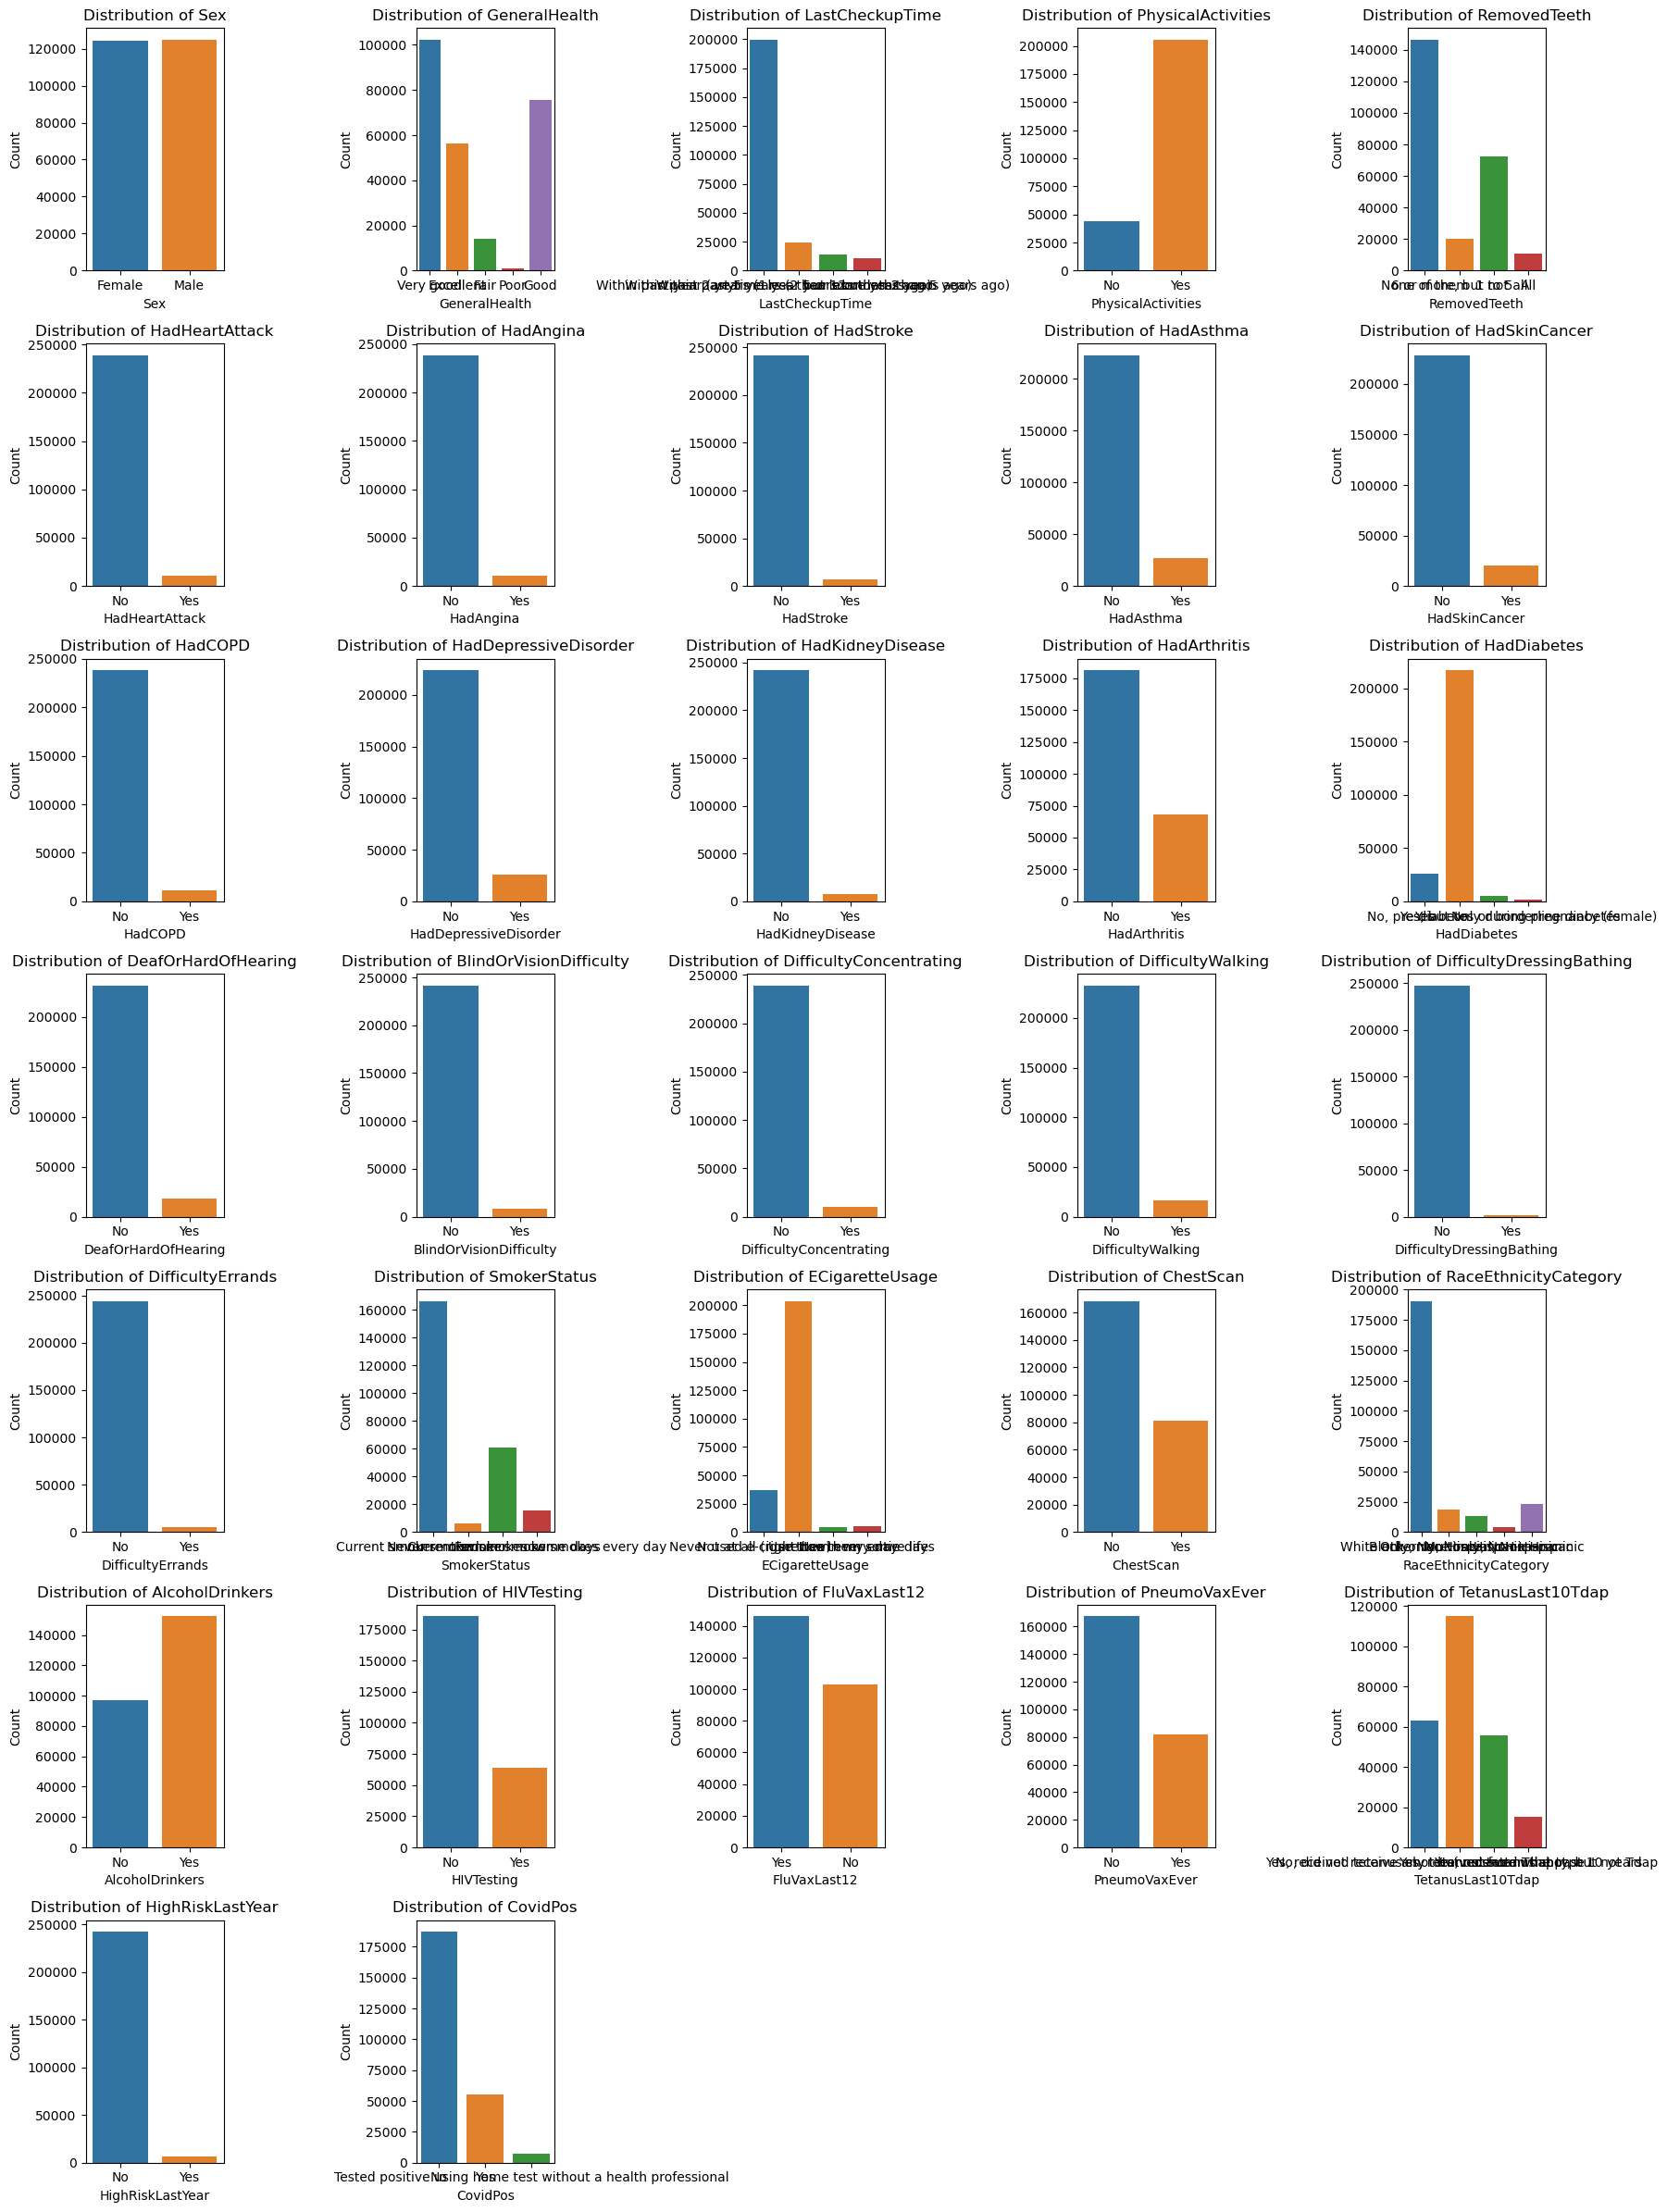

In [20]:
# Specify the categorical variables
categorical_vars = ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 
                    'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 
                    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 
                    'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 
                    'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 
                    'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 
                    'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AlcoholDrinkers', 
                    'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 
                    'HighRiskLastYear', 'CovidPos']

plt.figure(figsize=(18, 24))  # Set the figure size
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(7, 5, i)  # Create a subplot grid
    sns.countplot(x=var, data=data2)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [21]:
# Statistical Summaries
# Test for differences in means (e.g., General Health between Smokers and Non-Smokers)
smokers = data2[data2['SmokerStatus'] == 'Smoker']
non_smokers = data2[data2['SmokerStatus'] == 'Non-Smoker']

# Check for missing data and drop if necessary to ensure equal lengths
smokers.dropna(subset=['GeneralHealth'], inplace=True)
non_smokers.dropna(subset=['GeneralHealth'], inplace=True)

In [22]:
# Perform t-test
t_stat, p_value = ttest_ind(smokers['GeneralHealth'], non_smokers['GeneralHealth'])
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Calculate correlation between two numerical variables (e.g., BMI and Physical Health Days)
corr_coefficient, p_value = pearsonr(data2['BMI'], data2['PhysicalHealthDays'])
print(f"Pearson Correlation Coefficient: {corr_coefficient}, P-Value: {p_value}")

# Compute confidence intervals for key statistics (e.g., mean of Physical Health Days)
mean_physical_health_days = data2['PhysicalHealthDays'].mean()
std_physical_health_days = data2['PhysicalHealthDays'].std()
n_samples = len(data2['PhysicalHealthDays'])
confidence_interval = 1.96 * (std_physical_health_days / (n_samples ** 0.5))  # Assuming 95% confidence level
lower_bound = mean_physical_health_days - confidence_interval
upper_bound = mean_physical_health_days + confidence_interval
print(f"Confidence Interval for Mean Physical Health Days: ({lower_bound}, {upper_bound})")

T-Statistic: nan, P-Value: nan
Pearson Correlation Coefficient: 0.015353034961415393, P-Value: 1.7652166287574312e-14
Confidence Interval for Mean Physical Health Days: (0.19283258514753338, 0.19712939325876827)


In [23]:
# Create a Health Risk Score as a combination of various health indicators
def calculate_health_risk(row):
    score = 0
    health_conditions = ['HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
                         'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes']
    
    for condition in health_conditions:
        if row[condition] == 'Yes':
            score += 1
            
    return score

data2['HealthRiskScore'] = data2.apply(calculate_health_risk, axis=1)

# Verify the new feature
print(data2[['HealthRiskScore']].head())

   HealthRiskScore
0                1
1                1
2                1
3                2
4                0


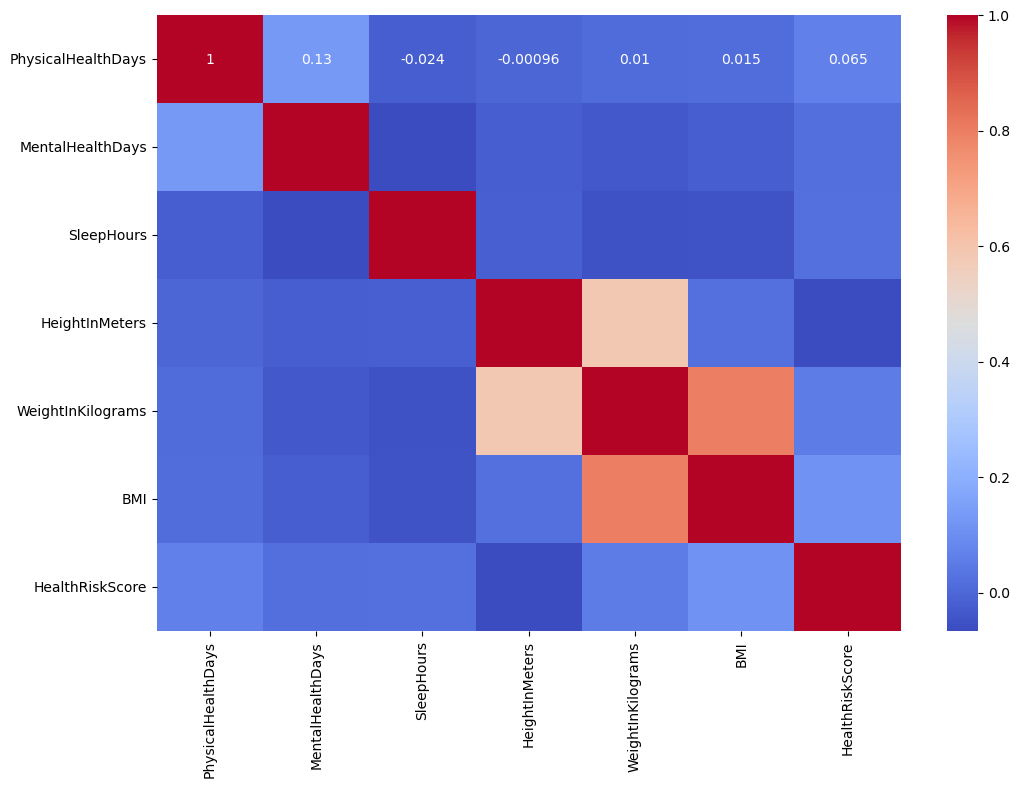

Highly correlated features with 'HealthRiskScore': ['HealthRiskScore']


In [24]:
# Check if 'HealthRiskScore' is in the DataFrame
if 'HealthRiskScore' not in data2.columns:
    print("'HealthRiskScore' column not found in the DataFrame.")
else:
    # Filter only numeric columns
    numeric_data2 = data2.select_dtypes(include=[float, int])

    # Calculate the correlation matrix
    corr_matrix = numeric_data2.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Selecting features with high correlation with 'HealthRiskScore'
    correlation_threshold = 0.3  # Set a threshold for correlation
    if 'HealthRiskScore' in corr_matrix.columns:
        correlated_features = corr_matrix['HealthRiskScore'][abs(corr_matrix['HealthRiskScore']) > correlation_threshold].index.tolist()
        print("Highly correlated features with 'HealthRiskScore':", correlated_features)
    else:
        print("'HealthRiskScore' not found in correlation matrix.")

In [25]:
#Feature Scaling and Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data2.loc[:, numerical_vars] = scaler.fit_transform(data2[numerical_vars])
print("..")

..


In [26]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings

warnings.filterwarnings("ignore")

# Usage of Evaluation Metrics: Precision and Recall
# Validation: Validation is essential to ensure that the model performs well on unseen data.
# It helps in preventing overfitting and provides an unbiased evaluation of model performance.

# Splitting data into features (X) and target variable (y)
X = data2.drop(columns=['GeneralHealth'])
y = data2['GeneralHealth']

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)
y = y.astype('category').cat.codes  # Convert target variable to numeric codes

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "XGBoost": XGBClassifier()
}

# Function to train and evaluate a single model sequentially
def sequential_train_and_evaluate(model_name, model):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    return model_name, training_time, accuracy, precision, recall

# Sequential Training and Evaluation
print("Sequentially Training and Evaluating models...")

sequential_results = []
for name, model in models.items():
    model_name, training_time, accuracy, precision, recall = sequential_train_and_evaluate(name, model)
    sequential_results.append((model_name, training_time, accuracy, precision, recall))
 
    print(f"{name} Sequential Accuracy: {accuracy:.4f}")
    print(f"{name} Sequential Precision: {precision:.4f}")
    print(f"{name} Sequential Recall: {recall:.4f}")

# Select the best-performing algorithm based on accuracy (or any other metric you prefer)
best_model_name, best_model_accuracy, _, _, _ = max(sequential_results, key=lambda item: item[2])
print(f"Best model based on accuracy: {best_model_name} with accuracy {best_model_accuracy}")

# Assuming Gradient Boosting is one of the best, or replace it with the actual best model
if best_model_name == "Gradient Boosting":
    best_model = GradientBoostingClassifier()
elif best_model_name == "Random Forest":
    best_model = RandomForestClassifier()
elif best_model_name == "Decision Tree":
    best_model = DecisionTreeClassifier()
elif best_model_name == "Logistic Regression":
    best_model = LogisticRegression(max_iter=10000)
elif best_model_name == "XGBoost":
    best_model = XGBClassifier()

# It is not impossible but yes it will take a lot of time to find the best parameters.
# In this case, just use three or two parameters for hyperparameter tuning.
param_grid = {
    'n_estimators': [50, 100],  # Reduced number of options
    'max_depth': [3, 5]         # Reduced number of options
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=3)

print("Tuning the best-performing algorithm...")
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the tuned model
print("Evaluating the tuned model...")
best_tuned_model = grid_search.best_estimator_
y_pred = best_tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Tuned Model Accuracy:", accuracy)
print("Tuned Model Precision:", precision)
print("Tuned Model Recall:", recall)

Sequentially Training and Evaluating models...
Random Forest Sequential Accuracy: 0.4563
Random Forest Sequential Precision: 0.4493
Random Forest Sequential Recall: 0.4563
Gradient Boosting Sequential Accuracy: 0.4714
Gradient Boosting Sequential Precision: 0.4656
Gradient Boosting Sequential Recall: 0.4714
Decision Tree Sequential Accuracy: 0.3714
Decision Tree Sequential Precision: 0.3701
Decision Tree Sequential Recall: 0.3714
Logistic Regression Sequential Accuracy: 0.4711
Logistic Regression Sequential Precision: 0.4653
Logistic Regression Sequential Recall: 0.4711
XGBoost Sequential Accuracy: 0.4718
XGBoost Sequential Precision: 0.4625
XGBoost Sequential Recall: 0.4718
Best model based on accuracy: XGBoost with accuracy 18.37015700340271
Tuning the best-performing algorithm...
Best parameters found:  {'max_depth': 3, 'n_estimators': 100}
Evaluating the tuned model...
Tuned Model Accuracy: 0.47269737501754666
Tuned Model Precision: 0.46695758375415986
Tuned Model Recall: 0.4726973

In [27]:
from sklearn.metrics import precision_score, recall_score

# Iterate over each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the labels for the test data
    y_pred = model.predict(X_test)
    
    # Calculate precision and recall scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Print precision and recall scores for each model
    print(f"{name} Precision:", precision)
    print(f"{name} Recall:", recall)

Random Forest Precision: 0.450309519719263
Random Forest Recall: 0.45890067579762167
Gradient Boosting Precision: 0.4655503947053316
Gradient Boosting Recall: 0.4714139611366234
Decision Tree Precision: 0.3675381669122728
Decision Tree Recall: 0.3690617041329938
Logistic Regression Precision: 0.4652535429561157
Logistic Regression Recall: 0.47113321435017147
XGBoost Precision: 0.462499550192187
XGBoost Recall: 0.47181502797441194


In [38]:
import pickle
from xgboost import XGBClassifier

filename = "heart5.sav"
XGBoost = XGBClassifier()

# Train and fit the model

# Save the model to a pickle file
with open(filename, "wb") as file:
    pickle.dump(XGBoost, file)